In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from utils.dataframe import get_final_dataframe

df = get_final_dataframe("random_forest")

2025-05-04 11:59:25,952 - data_processing.data_preprocessing - INFO - Applied one-hot encoding to ['surface', 'tourney_level', 'winner_entry', 'loser_entry', 'winner_hand', 'loser_hand']
2025-05-04 11:59:26,598 - data_processing.data_preprocessing - INFO - Columns successfully dropped -> ['tourney_name', 'tourney_id', 'match_num', 'winner_name', 'loser_name', 'score', 'best_of', 'round', 'minutes', 'w_ace', 'l_ace', 'w_df', 'l_df', 'w_svpt', 'l_svpt', 'w_1stIn', 'l_1stIn', 'w_1stWon', 'l_1stWon', 'w_2ndWon', 'l_2ndWon', 'w_SvGms', 'l_SvGms', 'w_bpSaved', 'l_bpSaved', 'w_bpFaced', 'l_bpFaced', 'Unnamed: 0', 'loser_entry_S']
2025-05-04 11:59:26,681 - data_processing.data_preprocessing - INFO - 89263 rows dropped
2025-05-04 11:59:27,311 - utils.dataframe - INFO - 52961 winners assigned to player 1
2025-05-04 11:59:27,312 - utils.dataframe - INFO - 52772 winners assigned to player 2
2025-05-04 11:59:27,735 - data_processing.feature_engineering - INFO - Applying feature engineering


In [2]:
columns_to_remove = [
    "player_1_entry_W", "player_2_entry_W", "player_1_entry_UP", "player_2_entry_UP",
    "player_1_entry_ITF", "player_2_entry_ITF", "player_1_entry_ALT",
    "player_2_entry_ALT", "player_1_entry_Alt", "player_2_entry_Alt",
    "player_1_entry_SE", "player_2_entry_SE", "player_1_entry_PR",
    "player_2_entry_PR", "tourney_level_F", "player_1_entry_LL",
    "player_2_entry_LL", "tourney_level_O"
]
df = df.drop(columns=[column for column in columns_to_remove])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105733 entries, 0 to 105538
Data columns (total 78 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   player_1_id                 105733 non-null  int64  
 1   player_1_seed               105733 non-null  float64
 2   player_1_ht                 105733 non-null  float64
 3   player_1_ioc                105733 non-null  int64  
 4   player_1_age                105733 non-null  float64
 5   player_1_rank               105733 non-null  float64
 6   player_1_rank_points        105733 non-null  float64
 7   player_1_entry_Q            105733 non-null  bool   
 8   player_1_entry_WC           105733 non-null  bool   
 9   player_1_hand_L             105733 non-null  bool   
 10  player_1_hand_R             105733 non-null  bool   
 11  player_1_was_seeded         105733 non-null  bool   
 12  player_2_id                 105733 non-null  int64  
 13  player_2_seed      

In [4]:
x = df.drop("player_1_won", axis=1)
y = df["player_1_won"]

In [5]:
x_train = df[df["tourney_year"] < 2024].drop("player_1_won", axis=1)
y_train = df[df["tourney_year"] < 2024]["player_1_won"]

x_test = df[df["tourney_year"] == 2024].drop("player_1_won", axis=1)
y_test = df[df["tourney_year"] == 2024]["player_1_won"]

# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.03, shuffle=False)

In [6]:
x_train.tail()

,player_1_id,player_1_seed,player_1_ht,player_1_ioc,player_1_age,player_1_rank,player_1_rank_points,player_1_entry_Q,player_1_entry_WC,player_1_hand_L,...,player_2_last_20_win_ratio,player_1_last_50_win_ratio,player_2_last_50_win_ratio,age_diff,player_1_elo,player_2_elo,elo_diff,player_1_surface_elo,player_2_surface_elo,surface_elo_diff
102554,209414,0.500000,178.0,10,19.5,0.014286,756.0,False,False,False,...,0.15,0.04,0.06,-0.8,1649.779273,1747.591681,-97.812408,1650.433657,1752.855312,-102.421655
102555,209414,0.500000,178.0,10,19.5,0.014286,756.0,False,False,False,...,0.05,0.04,0.02,-0.5,1622.566180,1508.660568,113.905612,1623.678925,1544.135139,79.543786
102556,210506,0.250000,193.0,2,19.2,0.010309,653.0,False,False,False,...,0.15,0.04,0.06,-1.1,1634.719988,1774.804774,-140.084786,1566.423746,1779.610043,-213.186297
102557,209406,0.125000,180.0,95,20.0,0.005405,326.0,False,False,True,...,0.10,0.00,0.04,0.8,1483.032492,1611.570511,-128.538020,1515.073667,1549.423343,-34.349675
102558,209098,0.166667,188.0,62,20.3,0.009091,582.0,False,False,False,...,0.05,0.06,0.02,0.3,1797.954250,1533.805940,264.148311,1796.610447,1556.269121,240.341325


array([[<Axes: title={'center': 'player_1_id'}>,
        <Axes: title={'center': 'player_1_seed'}>,
        <Axes: title={'center': 'player_1_ht'}>,
        <Axes: title={'center': 'player_1_ioc'}>,
        <Axes: title={'center': 'player_1_age'}>,
        <Axes: title={'center': 'player_1_rank'}>,
        <Axes: title={'center': 'player_1_rank_points'}>,
        <Axes: title={'center': 'player_2_id'}>],
       [<Axes: title={'center': 'player_2_seed'}>,
        <Axes: title={'center': 'player_2_ht'}>,
        <Axes: title={'center': 'player_2_ioc'}>,
        <Axes: title={'center': 'player_2_age'}>,
        <Axes: title={'center': 'player_2_rank'}>,
        <Axes: title={'center': 'player_2_rank_points'}>,
        <Axes: title={'center': 'draw_size'}>,
        <Axes: title={'center': 'tourney_year'}>],
       [<Axes: title={'center': 'tourney_month'}>,
        <Axes: title={'center': 'tourney_day'}>,
        <Axes: title={'center': 'rank_diff'}>,
        <Axes: title={'center': 'rank_

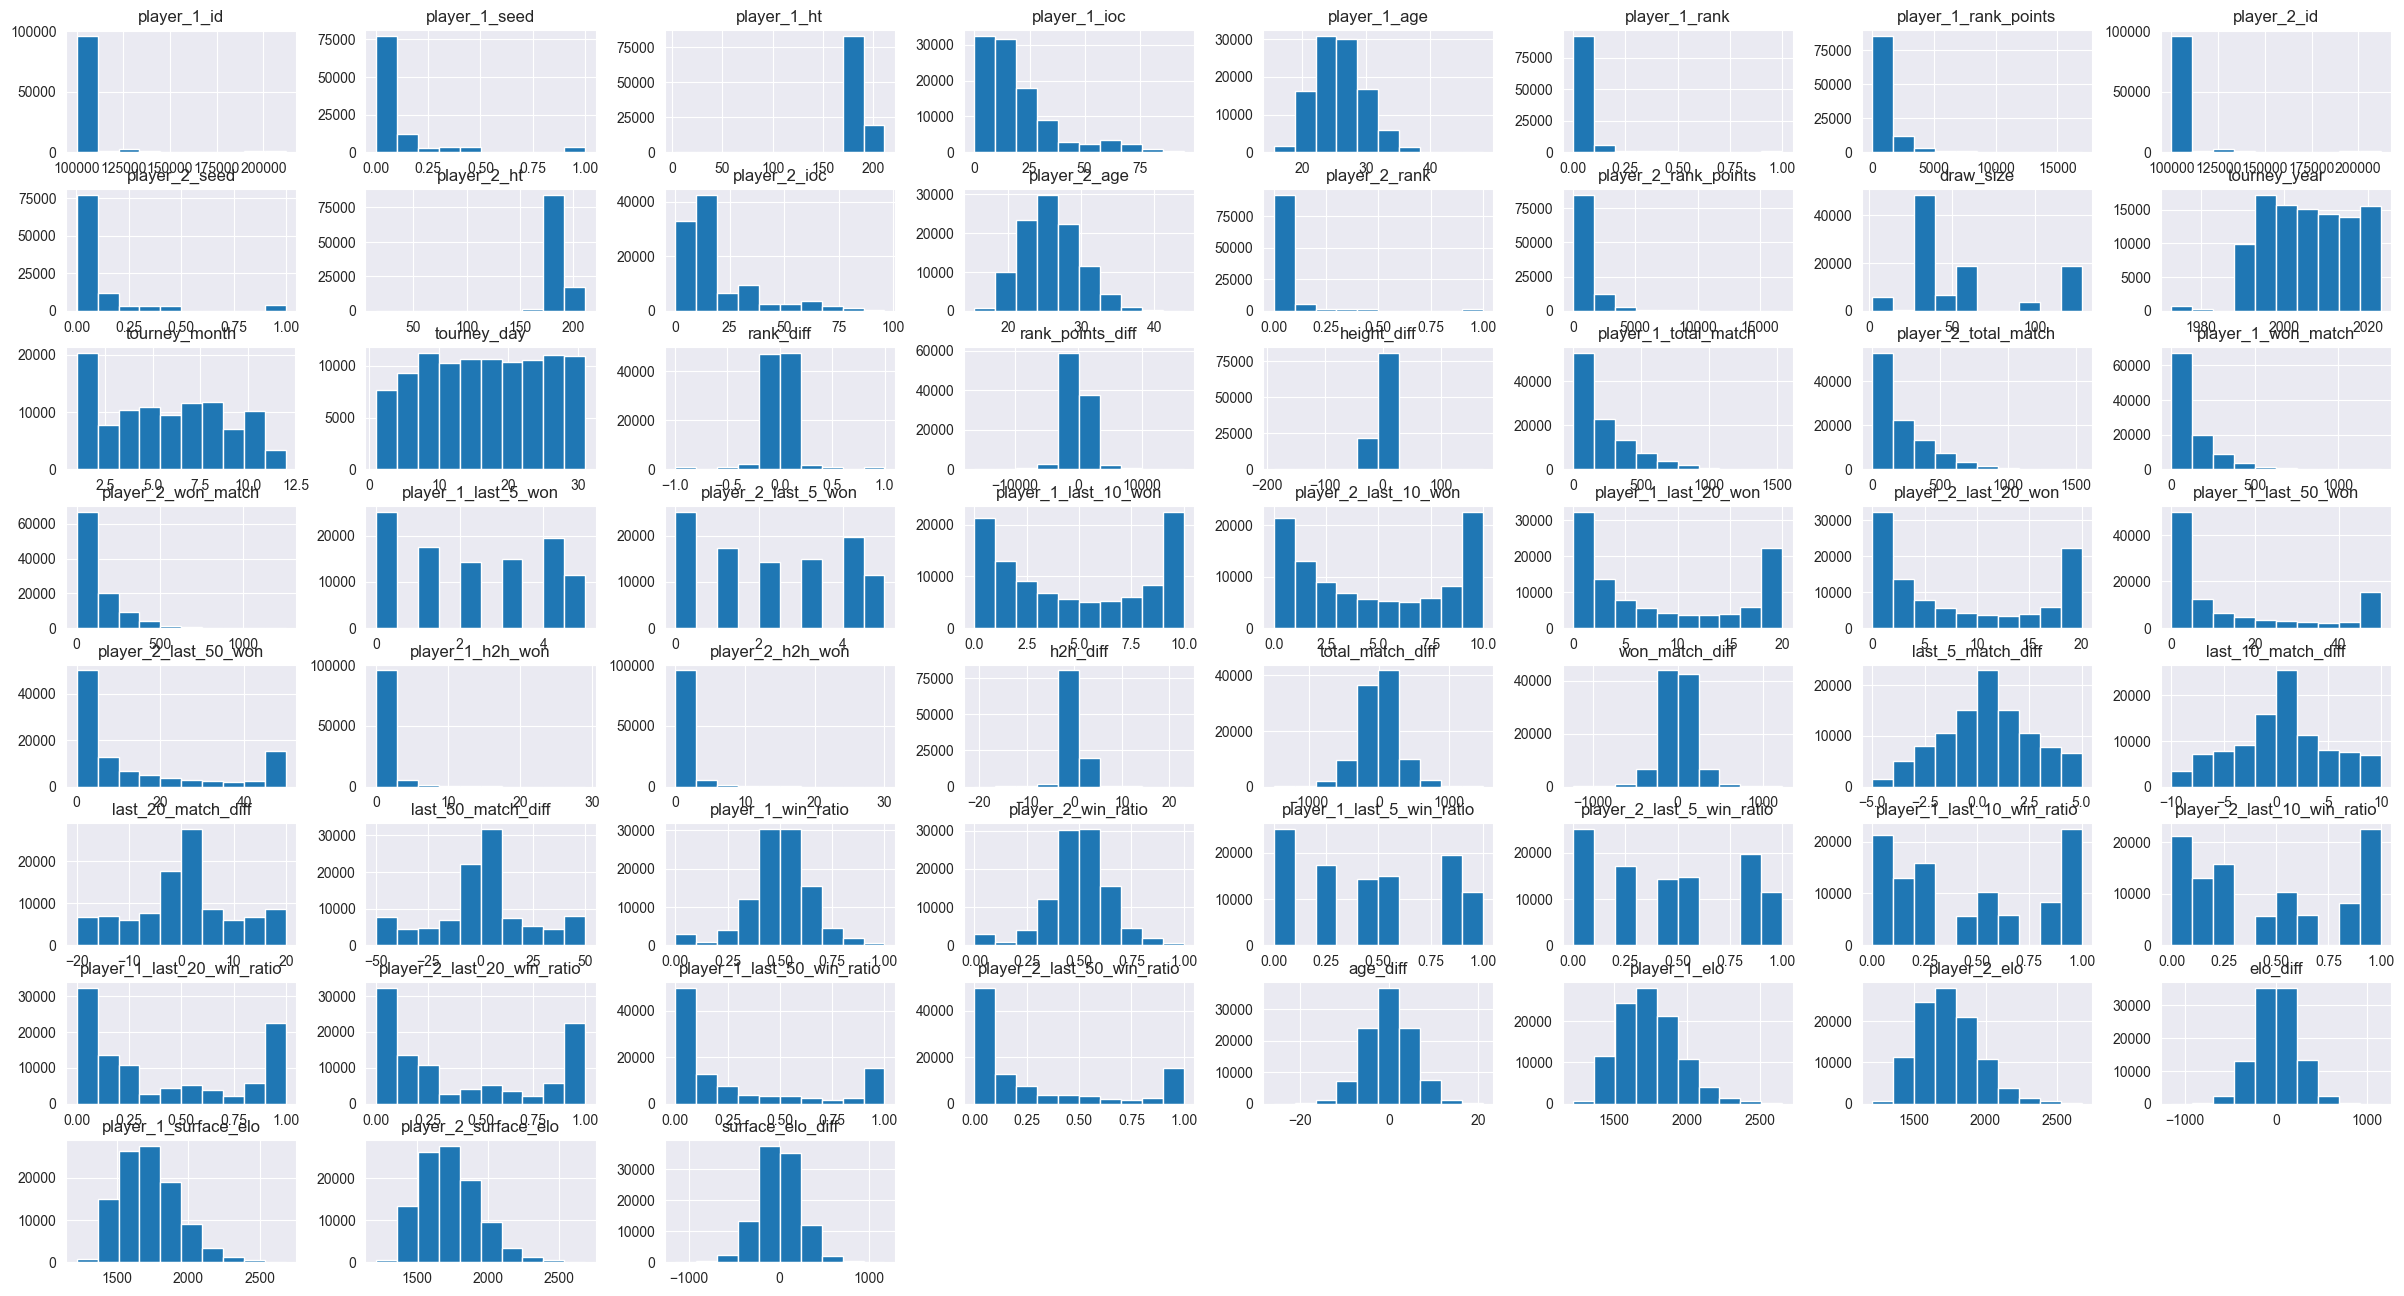

In [7]:
train_data = x_train.join(y_train)
train_data.hist(figsize=(30, 16))

<Axes: >

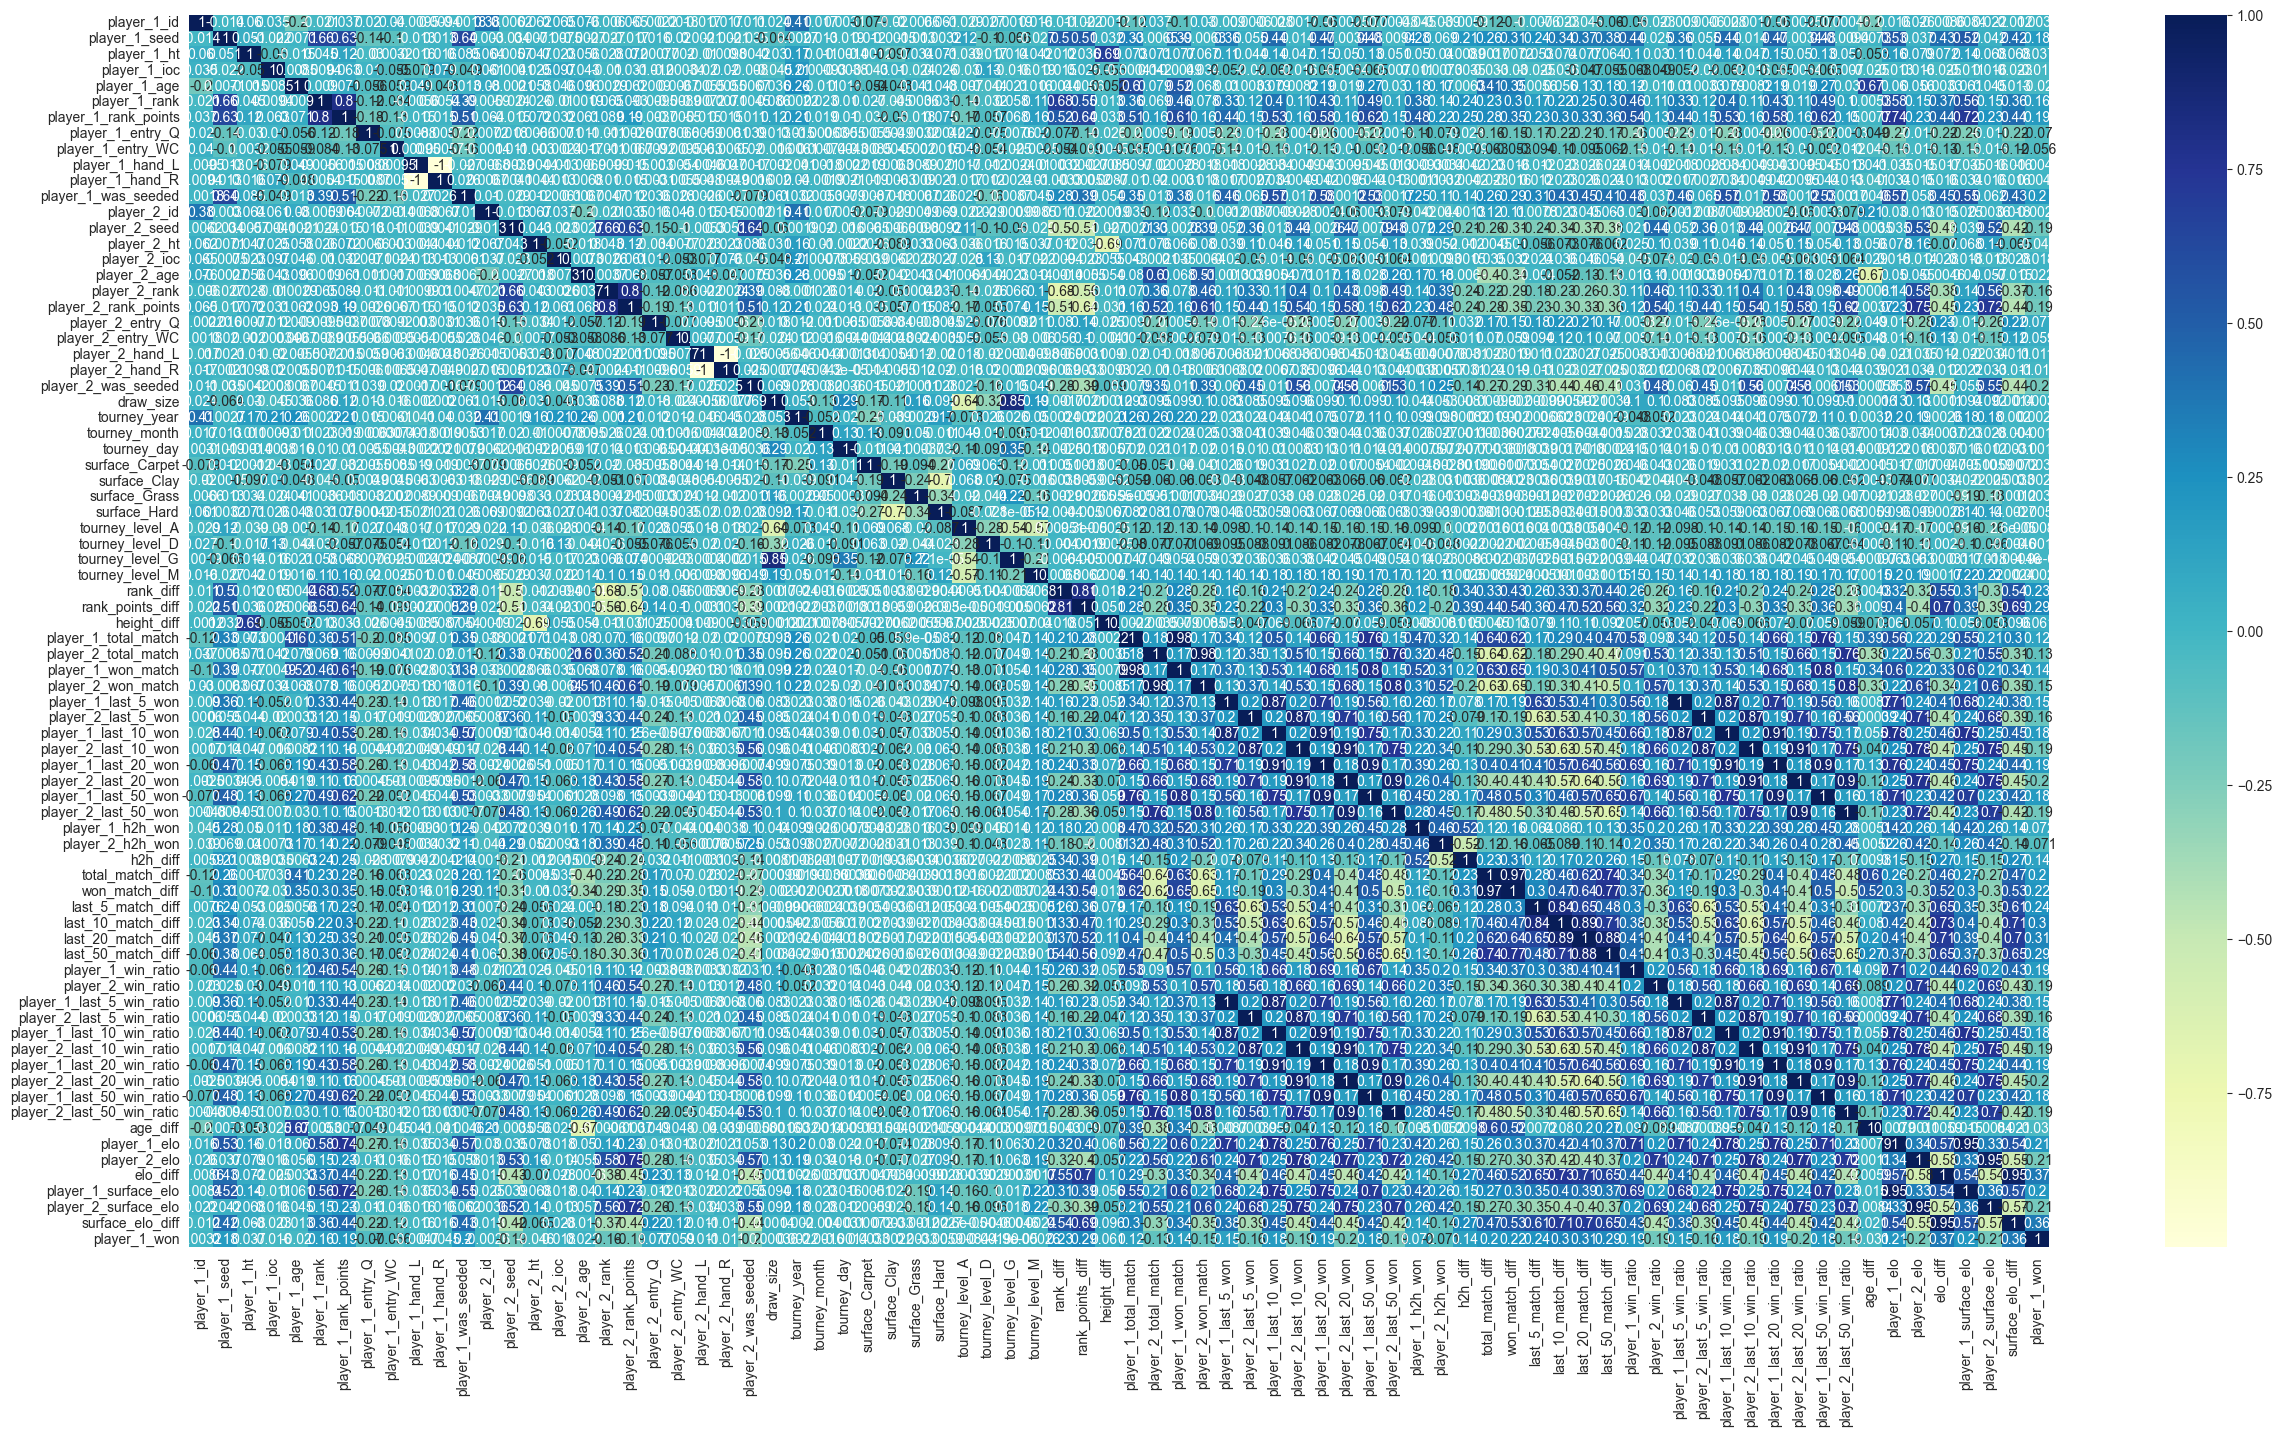

In [8]:
plt.figure(figsize=(30, 16))
sns.heatmap(train_data.corr(), annot = True, cmap = "YlGnBu")

In [12]:
from sklearn.ensemble import RandomForestClassifier

results = []
for state in range(50, 60):
    forest = RandomForestClassifier(random_state=state)
    forest.fit(x_train, y_train)

    accuracy = forest.score(x_test, y_test)
    results.append([state, accuracy])

results.sort(key=lambda x: x[1], reverse=True)
for state, accuracy in results:
    print(f"{state} random state model accuracy -> {accuracy *100}%")

54 random state model accuracy -> 65.5%
55 random state model accuracy -> 64.9%
53 random state model accuracy -> 64.53333333333333%
56 random state model accuracy -> 64.5%
51 random state model accuracy -> 64.4%
50 random state model accuracy -> 64.26666666666667%
59 random state model accuracy -> 64.06666666666668%
52 random state model accuracy -> 64.03333333333333%
58 random state model accuracy -> 63.93333333333333%
57 random state model accuracy -> 63.46666666666667%


In [22]:
forest = RandomForestClassifier(random_state=54)
forest.fit(x_train, y_train)

RandomForestClassifier(random_state=54)

In [23]:
accuracy = forest.score(x_test, y_test)
print(f"Model Accuracy -> {accuracy *100}%")

Model Accuracy -> 65.5%


In [24]:
importances = forest.feature_importances_
feature_names = x.columns
importance_list = [[feature, importance] for feature, importance in
                   zip(feature_names, importances)]

importance_list.sort(key=lambda x: x[1], reverse=True)
for feature, importance in importance_list:
    print(f"{feature}: {importance * 100}%")

elo_diff: 5.05337859761898%
surface_elo_diff: 4.619416285899808%
rank_points_diff: 4.0412325731155345%
rank_diff: 3.249664409360898%
won_match_diff: 2.5731807231067663%
age_diff: 2.3826241290717953%
player_2_elo: 2.369356789920501%
player_1_rank_points: 2.367724045635192%
player_2_rank_points: 2.359754786827041%
player_2_surface_elo: 2.354623773750551%
player_1_surface_elo: 2.330499706723325%
player_1_elo: 2.315010523624259%
total_match_diff: 2.2640015622372838%
player_2_win_ratio: 2.2437295991518287%
player_1_win_ratio: 2.231850722878207%
player_2_rank: 2.1904547416263367%
player_1_rank: 2.1755879199790114%
player_1_age: 2.171521277837715%
player_2_age: 2.15691333272945%
player_2_id: 1.9688721922386683%
player_1_id: 1.9597946937754882%
player_2_total_match: 1.9438378814627955%
player_1_total_match: 1.9419959284384058%
tourney_day: 1.8269777985907591%
player_1_won_match: 1.8180238334307228%
player_2_won_match: 1.795708523620769%
last_50_match_diff: 1.7856863610968967%
last_20_match_dif